In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt

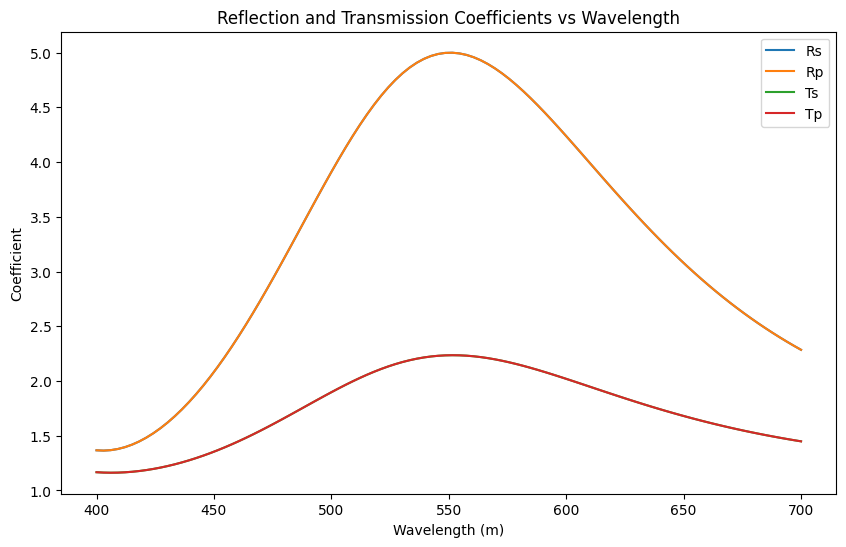

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def snell_law(n1, n2, theta1):
    stheta2 = n1 * torch.sin(theta1) / n2
    return torch.arcsin(stheta2)

def inters(n, theta):
    cos = torch.cos(theta)
    n = n.unsqueeze(-1)
    D = torch.stack([torch.ones_like(cos), torch.ones_like(cos), n * cos, -n * cos], dim=-1).reshape(-1, 2, 2)
    return D

def interp(n, theta):
    cos = torch.cos(theta)
    n = n.unsqueeze(-1)
    D = torch.stack([cos, cos, n, -n], dim=-1).reshape(-1, 2, 2)
    return D
def interp(n, theta):
    cos = torch.cos(theta)
    n = n.unsqueeze(-1).expand_as(cos)
    D = torch.stack([cos, cos, n, -n], dim=-1).reshape(-1, 2, 2)
    return D
def prop(theta, d, n, wavelength):
    phi = n * 2 * torch.pi / wavelength * torch.cos(theta) * d
    P = torch.stack([torch.exp(1j * phi), torch.zeros_like(phi), torch.zeros_like(phi), torch.exp(-1j * phi)], dim=-1).reshape(-1, 2, 2)
    return P

def multicapa(n, d, wavel_arr, theta0=0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    n = torch.tensor(n, device=device, dtype=torch.complex64)
    d = torch.tensor(d, device=device, dtype=torch.complex64)
    wavel_arr = torch.tensor(wavel_arr, device=device, dtype=torch.complex64)
    theta0 = torch.tensor(theta0, device=device, dtype=torch.complex64)

    # Inicializar theta para todas las longitudes de onda
    theta = torch.full((len(wavel_arr), 1), theta0, device=device)
    dtot = torch.eye(2, dtype=torch.complex64, device=device).unsqueeze(0).repeat(len(wavel_arr), 1, 1)
    
    for i in range(len(n) - 1):
        theta_next = snell_law(n[i], n[i + 1], theta[:, -1])
        theta = torch.cat((theta, theta_next.unsqueeze(1)), dim=1)

        D_next = inters(n[i + 1], theta[:, -1])
        Dinv_next = torch.linalg.inv(D_next)

        if i < len(d):
            P_next = prop(theta[:, -1], d[i], n[i + 1], wavel_arr)
            dtot = dtot @ D_next @ P_next @ Dinv_next
        else:
            dtot = dtot @ D_next @ Dinv_next

    D_last = inters(n[0], theta[:, -1])
    dtot = dtot @ D_last

    t = 1 / dtot[:, 0, 0]
    r = dtot[:, 1, 0] / dtot[:, 0, 0]
    Ts, Rs = coef_TR(t, r, theta0, theta[:, -1], n[0], n[0])

    theta = torch.full((len(wavel_arr), 1), theta0, device=device)
    dtot = torch.eye(2, dtype=torch.complex64, device=device).unsqueeze(0).repeat(len(wavel_arr), 1, 1)

    for i in range(len(n) - 1):
        theta_next = snell_law(n[i], n[i + 1], theta[:, -1])
        theta = torch.cat((theta, theta_next.unsqueeze(1)), dim=1)

        D_next = interp(n[i + 1], theta[:, -1])
        Dinv_next = torch.linalg.inv(D_next)

        if i < len(d):
            P_next = prop(theta[:, -1], d[i], n[i + 1], wavel_arr)
            dtot = dtot @ D_next @ P_next @ Dinv_next
        else:
            dtot = dtot @ D_next @ Dinv_next

    D_last = interp(n[0], theta[:, -1])
    dtot = dtot @ D_last

    t = 1 / dtot[:, 0, 0]
    r = dtot[:, 1, 0] / dtot[:, 0, 0]
    Tp, Rp = coef_TR(t, r, theta0, theta[:, -1], n[0], n[0])

    return Rs.cpu().numpy(), Rp.cpu().numpy(), Ts.cpu().numpy(), Tp.cpu().numpy()

def coef_TR(t, r, theta0, thetaf, n0, nf):
    T = nf / n0 * torch.abs(t) ** 2 * torch.cos(thetaf) / torch.cos(theta0)
    R = torch.abs(r) ** 2
    return T, R

# Ejemplo de uso
n =[1]+ [1.5, 1.3, 1.5] * 100 +[1]  # Índices de refracción
d = [100, 200]  # Espesores de las capas
wavel_arr = np.linspace(400, 700, 100)  # Array de longitudes de onda

# Resultados para diferentes longitudes de onda
Rs, Rp, Ts, Tp = multicapa(n, d, wavel_arr, theta0=np.pi / 180 * 0)

# Visualización de resultados
plt.figure(figsize=(10, 6))

plt.plot(wavel_arr, Rs, label='Rs')
plt.plot(wavel_arr, Rp, label='Rp')
plt.plot(wavel_arr, Ts, label='Ts')
plt.plot(wavel_arr, Tp, label='Tp')
plt.xlabel('Wavelength (m)')
plt.ylabel('Coefficient')
plt.legend()
plt.title('Reflection and Transmission Coefficients vs Wavelength')
plt.show()


In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def snell_law(n1, n2, theta1):
    stheta2 = n1 * torch.sin(theta1) / n2
    return torch.arcsin(stheta2)

def inters(n, theta):
    cos = torch.cos(theta)
    D = torch.zeros((theta.size(0), 2, 2), dtype=torch.complex64, device=theta.device)
    D[:, 0, 0] = 1
    D[:, 0, 1] = 1
    D[:, 1, 0] = n * cos
    D[:, 1, 1] = -n * cos
    return D

def interp(n, theta):
    cos = torch.cos(theta)
    D = torch.zeros((theta.size(0), 2, 2), dtype=torch.complex64, device=theta.device)
    D[:, 0, 0] = cos
    D[:, 0, 1] = cos
    D[:, 1, 0] = n
    D[:, 1, 1] = -n
    return D

def prop(theta, d, n, wavelength):
    phi = n * 2 * torch.pi / wavelength * torch.cos(theta) * d
    P = torch.zeros((theta.size(0), 2, 2), dtype=torch.complex64, device=theta.device)
    P[:, 0, 0] = torch.exp(1j * phi)
    P[:, 1, 1] = torch.exp(-1j * phi)
    return P

def multicapa(n, d, wavel_arr, theta0=0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    n = torch.tensor(n, device=device, dtype=torch.float64)
    d = torch.tensor(d, device=device, dtype=torch.float64)
    wavel_arr = torch.tensor(wavel_arr, device=device, dtype=torch.float64)
    theta0 = torch.tensor(theta0, device=device, dtype=torch.float64)
    theta0 = torch.tensor([theta0], device=device, dtype=torch.float64)  # Convert theta0 to a tensor with one dimension
    Rs_list = []
    Rp_list = []
    Ts_list = []
    Tp_list = []

    for wavel in wavel_arr:
        theta = [theta0]
        D = [inters(n[0], theta0).unsqueeze(0)]
        Dinv = [torch.linalg.inv(D[0])]
        P = [torch.eye(2, dtype=torch.complex64, device=device).unsqueeze(0)]
        dtot = Dinv[0]

        for i in range(len(n) - 1):
            theta.append(snell_law(n[i], n[i + 1], theta[-1]))

            D_next = inters(n[i + 1], theta[-1]).unsqueeze(0)
            Dinv_next = torch.linalg.inv(D_next)
            P_next = prop(theta[-1], d[i], n[i + 1], wavel).unsqueeze(0)
            dtot = dtot @ D_next @ P_next @ Dinv_next

        D_last = inters(n[-1], theta[-1]).unsqueeze(0)
        dtot = dtot @ D_last

        t = 1 / dtot[:, 0, 0]
        r = dtot[:, 1, 0] / dtot[:, 0, 0]
        Ts, Rs = coef_TR(t, r, theta0, theta[-1], n[0], n[-1])

        D = [interp(n[0], theta0).unsqueeze(0)]
        Dinv = [torch.linalg.inv(D[0])]
        dtot = Dinv[0]

        for i in range(len(n) - 1):
            theta.append(snell_law(n[i], n[i + 1], theta[-1]))

            D_next = interp(n[i + 1], theta[-1]).unsqueeze(0)
            Dinv_next = torch.linalg.inv(D_next)
            P_next = prop(theta[-1], d[i], n[i + 1], wavel).unsqueeze(0)
            dtot = dtot @ D_next @ P_next @ Dinv_next

        D_last = interp(n[-1], theta[-1]).unsqueeze(0)
        dtot = dtot @ D_last

        t = 1 / dtot[:, 0, 0]
        r = dtot[:, 1, 0] / dtot[:, 0, 0]
        Tp, Rp = coef_TR(t, r, theta0, theta[-1], n[0], n[-1])

        Rs_list.append(Rs.item())
        Rp_list.append(Rp.item())
        Ts_list.append(Ts.item())
        Tp_list.append(Tp.item())

    return np.array(Rs_list), np.array(Rp_list), np.array(Ts_list), np.array(Tp_list)


def multicapa(n, d, wavel_arr, theta0=0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    n = torch.tensor(n, device=device, dtype=torch.float64)
    d = torch.tensor(d, device=device, dtype=torch.float64)
    wavel_arr = torch.tensor(wavel_arr, device=device, dtype=torch.float64)
    theta0 = torch.tensor([theta0], device=device, dtype=torch.float64)  # Convert theta0 to a tensor with one dimension
    Rs_list = []
    Rp_list = []
    Ts_list = []
    Tp_list = []

    for wavel in wavel_arr:
        theta = [theta0]
        D = [inters(n[0], theta0).unsqueeze(0)]
        Dinv = [torch.linalg.inv(D[0])]
        P = [torch.eye(2, dtype=torch.complex64, device=device).unsqueeze(0)]
        dtot = Dinv[0]

        for i in range(len(n) - 1):
            theta.append(snell_law(n[i], n[i + 1], theta[-1]))

            D_next = inters(n[i + 1], theta[-1]).unsqueeze(0)
            Dinv_next = torch.linalg.inv(D_next)
            if i < len(d):  # Check if i is within the bounds of d
                P_next = prop(theta[-1], d[i], n[i + 1], wavel).unsqueeze(0)
                dtot = dtot @ D_next @ P_next @ Dinv_next

        D_last = inters(n[-1], theta[-1]).unsqueeze(0)
        dtot = dtot @ D_last

        t = 1 / dtot[:, 0, 0]
        r = dtot[:, 1, 0] / dtot[:, 0, 0]
        Ts, Rs = coef_TR(t, r, theta0, theta[-1], n[0], n[-1])

        D = [interp(n[0], theta0).unsqueeze(0)]
        Dinv = [torch.linalg.inv(D[0])]
        dtot = Dinv[0]

        for i in range(len(n) - 1):
            theta.append(snell_law(n[i], n[i + 1], theta[-1]))

            D_next = interp(n[i + 1], theta[-1]).unsqueeze(0)
            Dinv_next = torch.linalg.inv(D_next)
            if i < len(d):  # Check if i is within the bounds of d
                P_next = prop(theta[-1], d[i], n[i + 1], wavel).unsqueeze(0)
                dtot = dtot @ D_next @ P_next @ Dinv_next

        D_last = interp(n[-1], theta[-1]).unsqueeze(0)
        dtot = dtot @ D_last

        t = 1 / dtot[:, 0, 0]
        r = dtot[:, 1, 0] / dtot[:, 0, 0]
        Tp, Rp = coef_TR(t, r, theta0, theta[-1], n[0], n[-1])

        Rs_list.append(Rs.item())
        Rp_list.append(Rp.item())
        Ts_list.append(Ts.item())
        Tp_list.append(Tp.item())

    return np.array(Rs_list), np.array(Rp_list), np.array(Ts_list), np.array(Tp_list)

def coef_TR(t, r, theta0, thetaf, n0, nf):
    T = nf / n0 * torch.abs(t) ** 2 * torch.cos(thetaf) / torch.cos(theta0)
    R = torch.abs(r) ** 2
    return T, R

# Ejemplo de uso
n = [1] + [1.5, 1.3, 1.5] + [1]  # Índices de refracción
d = [100e-9, 200e-9]  # Espesores de las capas en metros
wavel_arr = np.linspace(400e-9, 700e-9, 100)  # Array de longitudes de onda

# Resultados para diferentes longitudes de onda
Rs, Rp, Ts, Tp = multicapa(n, d, wavel_arr, theta0=np.pi / 180 * 0)

# Visualización de resultados
plt.figure(figsize=(10, 6))
plt.plot(wavel_arr, Rs, label='Rs')
plt.plot(wavel_arr, Rp, label='Rp')
plt.plot(wavel_arr, Ts, label='Ts')
plt.plot(wavel_arr, Tp, label='Tp')
plt.xlabel('Wavelength (m)')
plt.ylabel('Coefficient')
plt.legend()
plt.title('Reflection and Transmission Coefficients vs Wavelength')
plt.show()


IndexError: index 1 is out of bounds for dimension 1 with size 1

c:\Users\Francisco\miniconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Francisco\miniconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


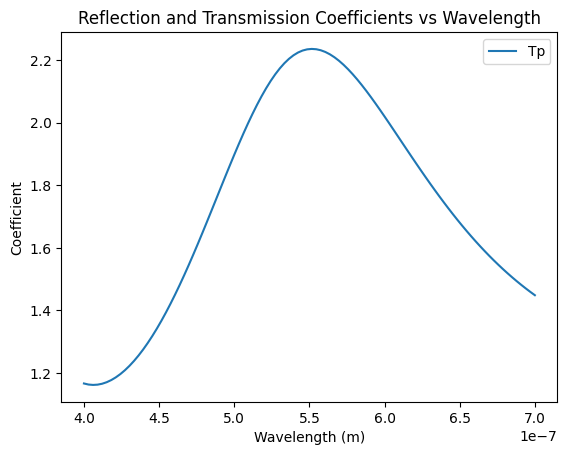

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def snell_law(n1, n2, theta1):
    stheta2 = n1 * torch.sin(theta1) / n2
    return torch.arcsin(stheta2)

def inters(n, theta):
    cos = torch.cos(theta)
    D = torch.stack([torch.ones_like(cos), torch.ones_like(cos), n * cos, -n * cos], dim=-1).reshape(-1, 2, 2)
    return D

def interp(n, theta):
    cos = torch.cos(theta)
    D = torch.stack([cos, cos, n, -n], dim=-1).reshape(-1, 2, 2)
    return D

def prop(theta, d, n, wavelength):
    phi = n * 2 * torch.pi / wavelength * torch.cos(theta) * d
    P = torch.stack([torch.exp(1j * phi), torch.zeros_like(phi), torch.zeros_like(phi), torch.exp(-1j * phi)], dim=-1).reshape(-1, 2, 2)
    return P

def multicapa(n, d, wavel_arr, theta0=0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    n = torch.tensor(n, device=device, dtype=torch.complex64)
    d = torch.tensor(d, device=device, dtype=torch.complex64)
    wavel_arr = torch.tensor(wavel_arr, device=device, dtype=torch.complex64)
    theta0 = torch.tensor(theta0, device=device, dtype=torch.complex64)

    # Inicializar theta para todas las longitudes de onda
    theta = torch.full((len(wavel_arr), 1), theta0, device=device)
    dtot = torch.eye(2, dtype=torch.complex64, device=device).unsqueeze(0).repeat(len(wavel_arr), 1, 1)
    
    for i in range(len(n) - 1):
        theta_next = snell_law(n[i], n[i + 1], theta[:, -1])
        theta = torch.cat((theta, theta_next.unsqueeze(1)), dim=1)

        D_next = inters(n[i + 1], theta[:, -1])
        Dinv_next = torch.linalg.inv(D_next)

        if i < len(d):
            P_next = prop(theta[:, -1], d[i], n[i + 1], wavel_arr)
            dtot = dtot @ D_next @ P_next @ Dinv_next
        else:
            dtot = dtot @ D_next @ Dinv_next

    D_last = inters(n[-1], theta[:, -1])
    dtot = dtot @ D_last

    t = 1 / dtot[:, 0, 0]
    r = dtot[:, 1, 0] / dtot[:, 0, 0]
    Ts, Rs = coef_TR(t, r, theta0, theta[:, -1], n[0], n[-1])

    theta = torch.full((len(wavel_arr), 1), theta0, device=device)
    dtot = torch.eye(2, dtype=torch.complex64, device=device).unsqueeze(0).repeat(len(wavel_arr), 1, 1)

    for i in range(len(n) - 1):
        theta_next = snell_law(n[i], n[i + 1], theta[:, -1])
        theta = torch.cat((theta, theta_next.unsqueeze(1)), dim=1)

        D_next = interp(n[i + 1], theta[:, -1])
        Dinv_next = torch.linalg.inv(D_next)

        if i < len(d):
            P_next = prop(theta[:, -1], d[i], n[i + 1], wavel_arr)
            dtot = dtot @ D_next @ P_next @ Dinv_next
        else:
            dtot = dtot @ D_next @ Dinv_next

    D_last = interp(n[-1], theta[:, -1])
    dtot = dtot @ D_last

    t = 1 / dtot[:, 0, 0]
    r = dtot[:, 1, 0] / dtot[:, 0, 0]
    Tp, Rp = coef_TR(t, r, theta0, theta[:, -1], n[0], n[-1])

    return Rs.cpu().numpy(), Rp.cpu().numpy(), Ts.cpu().numpy(), Tp.cpu().numpy()

def coef_TR(t, r, theta0, thetaf, n0, nf):
    T = nf / n0 * torch.abs(t) ** 2 * torch.cos(thetaf) / torch.cos(theta0)
    R = torch.abs(r) ** 2
    return T, R

# Ejemplo de uso
Rs = Rs.reshape(-1)
Rp = Rp.reshape(-1)
Ts = Ts.reshape(-1)
Tp = Tp.reshape(-1)
plt.plot(wavel_arr, Tp, label='Tp')
plt.xlabel('Wavelength (m)')
plt.ylabel('Coefficient')
plt.legend()
plt.title('Reflection and Transmission Coefficients vs Wavelength')
plt.show()


In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def snell_law(n1, n2, theta1):
    stheta2 = n1 * torch.sin(theta1) / n2
    return torch.arcsin(stheta2)

def inters(n, theta):
    cos = torch.cos(theta)
    D = torch.stack([torch.ones_like(cos), torch.ones_like(cos), n * cos, -n * cos], dim=-1).reshape(-1, 2, 2)
    return D

def interp(n, theta):
    cos = torch.cos(theta)
    D = torch.stack([cos, cos, n, -n], dim=-1).reshape(-1, 2, 2)
    return D

def prop(theta, d, n, wavelength):
    phi = n * 2 * torch.pi / wavelength * torch.cos(theta) * d
    P = torch.stack([torch.exp(1j * phi), torch.zeros_like(phi), torch.zeros_like(phi), torch.exp(-1j * phi)], dim=-1).reshape(-1, 2, 2)
    return P

def multicapa(n, d, wavel_arr, theta0=0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    n = torch.tensor(n, device=device, dtype=torch.complex64)
    d = torch.tensor(d, device=device, dtype=torch.complex64)
    wavel_arr = torch.tensor(wavel_arr, device=device, dtype=torch.complex64)
    theta0 = torch.tensor(theta0, device=device, dtype=torch.complex64)

    # Inicializar theta para todas las longitudes de onda
    theta = torch.full((len(wavel_arr), 1), theta0, device=device)
    dtot = torch.eye(2, dtype=torch.complex64, device=device).unsqueeze(0).repeat(len(wavel_arr), 1, 1)
    
    for i in range(len(n) - 1):
        theta_next = snell_law(n[i], n[i + 1], theta[:, -1])
        theta = torch.cat((theta, theta_next.unsqueeze(1)), dim=1)

        D_next = inters(n[i + 1], theta[:, -1])
        Dinv_next = torch.linalg.inv(D_next)

        if i < len(d):
            P_next = prop(theta[:, -1], d[i], n[i + 1], wavel_arr)
            dtot = dtot @ D_next @ P_next @ Dinv_next
        else:
            dtot = dtot @ D_next @ Dinv_next

    D_last = inters(n[-1], theta[:, -1])
    dtot = dtot @ D_last

    t = 1 / dtot[:, 0, 0]
    r = dtot[:, 1, 0] / dtot[:, 0, 0]
    Ts, Rs = coef_TR(t, r, theta0, theta[:, -1], n[0], n[-1])

    theta = torch.full((len(wavel_arr), 1), theta0, device=device)
    dtot = torch.eye(2, dtype=torch.complex64, device=device).unsqueeze(0).repeat(len(wavel_arr), 1, 1)

    for i in range(len(n) - 1):
        theta_next = snell_law(n[i], n[i + 1], theta[:, -1])
        theta = torch.cat((theta, theta_next.unsqueeze(1)), dim=1)

        D_next = interp(n[i + 1], theta[:, -1])
        Dinv_next = torch.linalg.inv(D_next)

        if i < len(d):
            P_next = prop(theta[:, -1], d[i], n[i + 1], wavel_arr)
            dtot = dtot @ D_next @ P_next @ Dinv_next
        else:
            dtot = dtot @ D_next @ Dinv_next

    D_last = interp(n[-1], theta[:, -1])
    dtot = dtot @ D_last

    t = 1 / dtot[:, 0, 0]
    r = dtot[:, 1, 0] / dtot[:, 0, 0]
    Tp, Rp = coef_TR(t, r, theta0, theta[:, -1], n[0], n[-1])

    return Rs.cpu().numpy(), Rp.cpu().numpy(), Ts.cpu().numpy(), Tp.cpu().numpy()

def coef_TR(t, r, theta0, thetaf, n0, nf):
    T = nf / n0 * torch.abs(t) ** 2 * torch.cos(thetaf) / torch.cos(theta0)
    R = torch.abs(r) ** 2
    return T, R

# Ejemplo de uso
n = [1] + [1.5, 1.3, 1.5] + [1]  # Índices de refracción
d = [100e-9, 200e-9]  # Espesores de las capas en metros
wavel_arr = np.linspace(400e-9, 700e-9, 100)  # Array de longitudes de onda

# Resultados para diferentes longitudes de onda
Rs, Rp, Ts, Tp = multicapa(n, d, wavel_arr, theta0=np.pi / 180 * 0)

# Visualización de resultados
plt.figure(figsize=(10, 6))

plt.plot(wavel_arr, Rs, label='Rs')
plt.plot(wavel_arr, Rp, label='Rp')
plt.plot(wavel_arr, Ts, label='Ts')
plt.plot(wavel_arr, Tp, label='Tp')
plt.xlabel('Wavelength (m)')
plt.ylabel('Coefficient')
plt.legend()
plt.title('Reflection and Transmission Coefficients vs Wavelength')
plt.show()


RuntimeError: stack expects each tensor to be equal size, but got [100] at entry 0 and [] at entry 2

In [20]:
import numpy as np

def snell_law(n1, n2, theta1):
    stheta2 = n1 * np.sin(theta1) / n2
    return np.arcsin(stheta2)

def inters(n, theta):
    cos = np.cos(theta)
    D = np.array([[1, 1], [n * cos, -n * cos]])
    return D

def interp(n, theta):
    cos = np.cos(theta)
    D = np.array([[cos, cos], [n, -n]])
    return D

def prop(theta, d, n, wavelength):
    phi = n * 2 * np.pi / wavelength * np.cos(theta) * d
    P = np.array([[np.exp(1j * phi), 0], [0, np.exp(-1j * phi)]])
    return P

def multicapa(n, d, wavel, theta0=0):
    theta = [theta0]
    D = [inters(n[0], theta0)]
    Dinv = [np.linalg.inv(D[0])]
    P = [0]
    dtot = Dinv[0]

    for i in range(len(n)-1):
        theta.append(snell_law(n[i], n[i+1], theta[-1]))

        D = inters(n[i+1], theta[i+1])
        Dinv = np.linalg.inv(D)
        P.append(prop(theta[i+1], d[i], n[i+1], wavel))
        dtot = dtot @ D @ P[i] @ Dinv

    D = inters(n[-1], theta[-1])
    dtot = dtot @ D

    t = 1 / dtot[0, 0]
    r = dtot[1, 0] / dtot[0, 0]
    Ts, Rs = coef_TR(t, r, theta0, theta[-1], n[0], n[-1])

    D = [interp(n[0], theta0)]
    Dinv = [np.linalg.inv(D[0])]
    dtot = Dinv[0]

    for i in range(len(n)-1):
        theta.append(snell_law(n[i], n[i+1], theta[-1]))

        D = interp(n[i+1], theta[i+1])
        Dinv = np.linalg.inv(D)
        dtot = dtot @ D @ P[i] @ Dinv

    D = interp(n[-1], theta[-1])
    dtot = dtot @ D

    t = 1 / dtot[0, 0]
    r = dtot[1, 0] / dtot[0, 0]
    Tp, Rp = coef_TR(t, r, theta0, theta[-1], n[0], n[-1])

    return Rs, Rp, Ts, Tp

def coef_TR(t, r, theta0, thetaf, n0, nf):
    T = nf / n0 * np.abs(t)**2 * np.cos(thetaf) / np.cos(theta0)
    R = np.abs(r)**2
    return T, R
